# Day 13: Unsupervised Learning


How do we find patterns in data if we know minimal amounts about the data? We are looking to group data - but without foreknowledge of what groups they belong to.

Examples of Unsupervised Learning:

*   Dividing customers into preselected groups to determine marketing plans.  
*   Identifying similar songs in a spotify database (without genre labels)
*   Trying to find members of a secret organization using nothing but their emails to and from one another.


In [1]:
#our second Pip, a very big install.
# !pip install pyclustertend

In [2]:
import numpy as np
import pandas as pd
import plotly.figure_factory as ff  #Simpler than scipy's clusering approach, also has great other features!
from sklearn import preprocessing #Gotta normalize several variables, better than doing it manually each time.
from sklearn.preprocessing import LabelEncoder #Label encoding, also a pain to do manually.
from sklearn.cluster import KMeans
# from pyclustertend.hopkins import hopkins #Hopkins Clustering

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

## Hierarchical Clustering

This proceedure is deceptively simple.

What makes a good group? Well, members of a group should be similar to one another.  More similar, smaller "distance" between numbers. Distance between members of a group should be small.

So, let's take the two closest data points, and gob them together. Track which groups are glued together and how far apart they were (in a dendrogram). Continue "gobbing" points together until we have 1 group. This way we can see which clusters of points are most naturally associated with one another and make a determination about appropriate groupings.

In [3]:
dfTitanic = pd.read_csv('titanic3.csv')
dfTitanic.head() #Time to look at data and select what seems like it might be good for grouping passengers together, can use several numerical values

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
#Everything has to be numeric, no NA's
labelInstance = LabelEncoder
minMaxInstance = preprocessing.MinMaxScaler()
dfTitanic['encSex'] = labelInstance().fit_transform(dfTitanic['sex'])
dfTitanic['hasBoat'] = pd.isna(dfTitanic['boat']).astype(int)  #Note that this encoding assumes a relationship between the boats in some quasilinear fashion!
dfTitanic[['stdFare','stdAge']] = minMaxInstance.fit_transform(dfTitanic[['fare','age']])   #It is vital that you standardize/normalize everything you can, otherwise the distance metrics are dominated by things like fare price and not by other elements.  Your choice here matters.
dfClean = dfTitanic[['pclass','survived','encSex','hasBoat','stdFare','stdAge']].dropna(how='any')
dfClean.head() #These are the columns we want.

,pclass,survived,encSex,hasBoat,stdFare,stdAge
0,1.0,1.0,0,0,0.412503,0.361169
1,1.0,1.0,1,0,0.295806,0.009395
2,1.0,0.0,0,1,0.295806,0.022964
3,1.0,0.0,1,1,0.295806,0.373695
4,1.0,0.0,0,1,0.295806,0.311064


In [5]:
fig = ff.create_dendrogram(dfClean[1:50]) #only draw a few, we want to see the tree with some
fig.update_layout(width=800, height=500)
fig.show()

These figures are read from the bottom up. The vertical axis indicates "distance from each other". As clusters are allowed to have more distant parts, they are naturally larger, and there will be fewer clusters.

To read these, let us take a few horizontal cross-sections.
1.   At distance 0, there are over a dozen or so smaller groups, mostly just pairs of passengers, such as the 2-person cluster 41 & 28
2.   These eventually aggregate. At distance 1.25, there are only 4 groups left, the far left "green group", the "orange group" and then the "light blue" and "purple" groups.  This can be found by putting your finger at about 1.25 on the y-axis and moving directly left-to-right. Each time you cross a new line, a new group is indicated.
3.   At distance 2, everything has been aggregated into a single group.


Behind the scenes, there are different methods of determining distance of groups, the most obvious perhaps being 'average linkage' of all points in cluster between one another, 'single linkage' (distance between two closest points), and so on. Check your textbook for variations, but these generally cover the ideas of note.

Critically, because this actually measures distance, one **must** use normalized/standardized data. **Results will vary by normalization/standardization choices.**  

One indicator that I have normalized my data is that *nothing* has numerical values greater than 1 or less than 0 in my entire dataset.   
Another is that the total distance (2, the peak of the vertical axis) is less than the number of features I am using.

## K-Means Clustering

Rather than start with the data and find the number of groups (at a given distance), one could designate a number of groups that we believe to be present in the data, then search for an appropriate match.

Matches are determined by randomly assigning points to a cluster.
We then find a centroid for all points in that cluster.
Then we reassign observations to the closest centroid, and repeat until stablized.  Note that because this starts with a random point, it is **nondeterministic** in outcome.

Note that an labeled group is not guranteed to be found in this data. This is looking for unlabeled groups. For example, if I feed it every factor except for survival, it will not almost certainly not identify the group survive/not survive.  

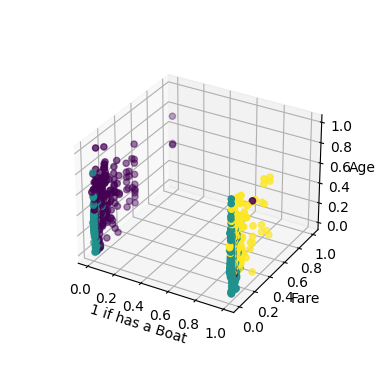

In [6]:
kmeans = KMeans(n_clusters=3, n_init=1234) #selecting arbitrary random seed
kmeans.fit(dfClean)

ax = plt.axes(projection='3d')
ax.scatter3D(dfClean['hasBoat'], dfClean['stdFare'], dfClean['stdAge'], c=kmeans.labels_);

ax.set_xlabel('1 if has a Boat')
ax.set_ylabel('Fare')
ax.set_zlabel('Age')
ax.set_box_aspect(aspect=None, zoom=0.75)
plt.show()

Boats were a major component of the grouping, boats are seen as contiguous, but are likely stored on different floors, etc. - this is worth a long discussion and several explorations - if we had encoded boats by number, we will get totally different results...

## Association Rules

We have a series of items (usually events occuring in time), and we are looking to see how often the antecedent (event before) is followed by a consequent (event after).  We will call the antecdent A and the consequent B.

$P(B|A) = Confidence = \frac{P(A and B)}{P(A)}$

However, this does not mean A *causes* B, those things are distinct. For example, if B simply happens all the time, then this confidence will be very high, because $P(B) \approx 1$.   One way to correct for this specific problem is to use the lift ratio (but doesn't solve the problem entirely)

$Lift\ Ratio = \frac{Confidence}{P(B)}$

If this lift ratio exceeds 1 it suggests a rule might be useful, at least, moreso than not using A.  However, one should be cautious about how frequently both A and B occur in the dataset, one would not want to perform this evaluation when either A or B were partiuclarly sparse.



## Measuring Clustering

Broadly, we would like to know if a given dataset has suitability for unsupervised clustering. We can do this with *a priori* knowledge, or by visual inspection, and then complement or approach with an autonomous measure (like a Hopikins Statistic).

We also would like to know if a clustering is well-done, given that some clusters are good and others are clearly... not.  One autonomous measure is the *Silhouette coefficient*.

### Hopkins Statistic


In [7]:
#Generally returns 0.5 if uniformly distributed, closer to 0 means more clusters.
#Note in large data sets natural lumps will trigger this to shrink because real data deviates from theoretical norms, larger data sets are more likely to have such lumps.
#One might argue such lumps are indeed clusters of note, but the roughness of the surface limits the ability to find whatever true groupings we believe to be present.
hopkins(dfClean, 200)

NameError: name 'hopkins' is not defined

## Silhoette Coefficient

$s(i) = \frac{b(i)-a(i)}{max(a(i),b(i)}$

Where *a(i)* is the mean distance between point *i* and members of cluster A, and *b(i)* is the measure of mean distance to members of cluster B.

Ranges from -1 to 1, 1 meaning point *i* similar to cluster A, and -1 means *i* is more similar to members of cluster B.

# Exercizes

1) Discuss and explain why the siloette coefficient is vunerable to choices in scaling. Try to sketch out an example verbally.

2) Load a fresh dataset and make a call about the number of clusters using a hirerarical clustering method.

3) Load a fresh dataset and make a call about the number of clusters using a K-means cluster.

4) Construct an elbow plot for the K-means plot and discuss.